# Fit the spin waves

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pylib.plotformat as pf
from numba import njit
import warnings
from copy import deepcopy
from matplotlib.colors import Normalize, LogNorm
from matplotlib import cm

from pylib.HeisenbergFMSpinWave import hw_ac, hw_op, chisquared, dists, MyData, globalerror, plotresult

In [5]:
exchnames = [1,2,3,4,5,  7,8,  11,  13, 15, 17]
def noC(JJ):
    if len(JJ) > 10:
        fitJJ = np.hstack((JJ[:5], 0, JJ[5:7], 0,0, JJ[7], 0, JJ[8], 0, JJ[9], 0, JJ[10]))
    elif len(JJ) > 9:
        fitJJ = np.hstack((JJ[:5], 0, JJ[5:7], 0,0, JJ[7], 0, JJ[8], 0, JJ[9]))
    elif len(JJ) > 8:
        fitJJ = np.hstack((JJ[:5], 0, JJ[5:7], 0,0, JJ[7], 0, JJ[8]))
    elif len(JJ) > 7:
        fitJJ = np.hstack((JJ[:5], 0, JJ[5:7], 0,0, JJ[7]))
    elif len(JJ) > 5:
        fitJJ = np.hstack((JJ[:5], 0, JJ[5:7]))
    else:
        fitJJ = JJ
    return fitJJ

def chisquared_noC(JJ):
    return chisquared(noC(JJ))

In [6]:
Jguess = np.array([-2.0, -4.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Jfurthest = np.arange(2,12)
JJbestfits = []
ChisqBestFits = []

for i in Jfurthest:
    print(i, end=', ')
    if i < len(Jguess):
        JJfit = deepcopy(Jguess[:i])
    elif i == len(Jguess):
        JJfit = deepcopy(Jguess)
    else:
        JJfit = np.hstack((Jguess, np.zeros(i-len(Jguess))+0.005))
    JJfit[-1] += 0.006

    res0 = minimize(chisquared_noC,x0 = JJfit, method='Powell')
    print(res0.fun, end = ', ')
    ### Fit from the best chisquared
    res = minimize(chisquared_noC, x0 = res0.x)
    JJbfit = np.hstack((res.x, np.zeros(Jfurthest[-1]-i)))
    print(res.fun, JJbfit)
    JJbestfits.append(JJbfit)
    ChisqBestFits.append([res.fun, exchnames[i-1]])

2, 581.9358129068065, 581.9358129068039 [-2.07938481 -3.81509801  0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
3, 79.29915522697513, 79.29915357629382 [-1.67015075 -3.64572663 -1.73013525  0.          0.          0.
  0.          0.          0.          0.          0.        ]
4, 79.66293192916551, 79.66264251972801 [-1.67716294 -3.64888797 -1.73996542  0.01225207  0.          0.
  0.          0.          0.          0.          0.        ]
5, 66.30888637976294, 66.3088135976728 [-1.8523564  -3.48919413 -1.61012305 -0.02984851 -0.19528301  0.
  0.          0.          0.          0.          0.        ]
6, 45.278178011356474, 45.275937348649414 [-2.0733413  -3.59861087 -1.50769808 -0.08824057 -0.10979372  0.39443778
  0.          0.          0.          0.          0.        ]
7, 13.5817795210579, 13.581758289325485 [-1.90337991 -3.37923345 -1.66980575 -0.0933454  -0.08959283  0.36647822
 -0.29314779  0.          0.          0.   

In [7]:
np.savetxt('SpinWave_fitresults/Chisq_vs_neighbor.txt',
           np.hstack((np.array(ChisqBestFits), np.array(JJbestfits) )), header=' Chi2, Ji...')

<IPython.core.display.Javascript object>


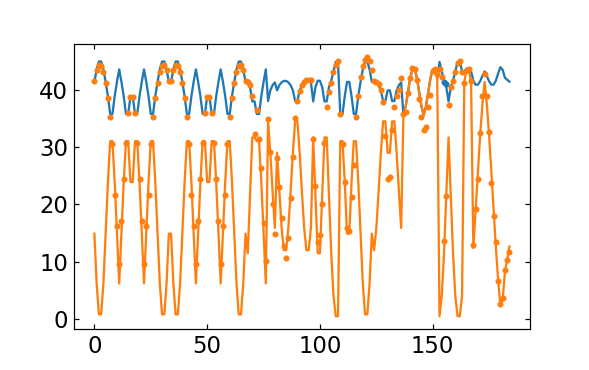

/home/1o1/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [5]:
plotresult(MyData, noC(res0.x))

### I think we can truncate at 8nn in plane.
 chi2 doesn't appreciably decrease when you add beyond this

In [6]:
Chisqglobalbest = ChisqBestFits[-3][0]
JJglobalbest = JJbestfits[-3][:-2]
print(Chisqglobalbest, JJglobalbest)

13.581758289325485 [-1.90337991 -3.37923345 -1.66980575 -0.0933454  -0.08959283  0.36647822
 -0.29314779]


# Determine uncertainty
Do a systematic minimization search, then a stochastic search

In [7]:
Chisq_list = []
JJ_list = []

### Systematic minimization
for i in range(len(JJglobalbest)):
    print('fitting', i, '...')
    # Define range of allowed fitted values:   
    for jj in [-1,1]:
        value = JJglobalbest[i]
        if i in [0,2]:   step = jj*JJglobalbest[i]/300
        elif i == 1: step = jj*JJglobalbest[i]/600
        else:       step = jj*JJglobalbest[i]/60
        oldJJ = deepcopy(JJglobalbest)
        while True:
            def stitchJ(xx):
                return np.hstack((xx[:i],value, xx[i:]))
            def fitfun(xx):
                return chisquared_noC(stitchJ(xx))

            res2 = minimize(fitfun, x0 = np.hstack((oldJJ[:i], oldJJ[i+1:])), method='Powell')
            oldJJ = stitchJ(res2.x)

            if res2.fun > (Chisqglobalbest+1):
                break
            else:
                value += step
                Chisq_list.append(res2.fun)
                JJ_list.append(oldJJ)
            
JJ_list = np.array(JJ_list)

fitting 0 ...
fitting 1 ...
fitting 2 ...
fitting 3 ...
fitting 4 ...
fitting 5 ...
fitting 6 ...


<IPython.core.display.Javascript object>


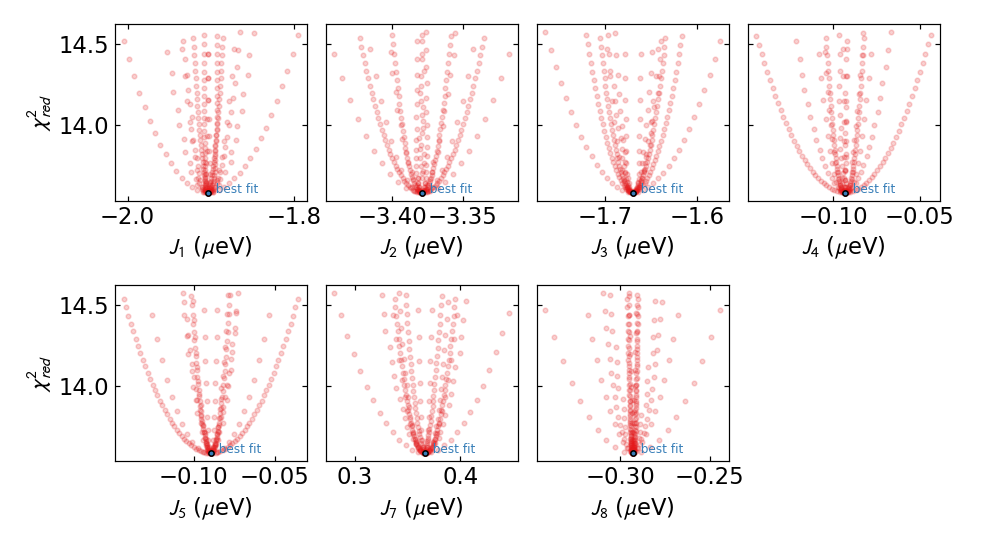

In [8]:
f, ax = plt.subplots(2,4,figsize=(9,5), sharey=True)

sf = 1
markerprops = {'ls':'none', 'marker':'.', 'rasterized':True}

axes= ax.flatten()
for i, axx in enumerate(axes):
    jind = i        
    try:
        axx.plot(JJ_list[:,jind]*sf, Chisq_list, alpha=0.2, **markerprops)
        axx.set_xlabel('$J_{'+str(exchnames[jind])+'}$ ($\\mu$eV)')
        axx.plot(JJglobalbest[jind]*sf, Chisqglobalbest, ms=7, mec='k', ls='none', marker='.')
        axx.text(JJglobalbest[jind]*sf, Chisqglobalbest, '  best fit', color=pf.cpal1[1], fontsize=8)
    except IndexError:
        axx.axis('off')
        
for i in range(len(ax)):
    ax[i,0].set_ylabel('$\\chi^2_{red}$')

plt.tight_layout()
f.subplots_adjust(wspace=0.1)

In [9]:
## Save best fit parameters and chisquared ditributions
np.save('SpinWave_fitresults/Chisq_list_1.npy', Chisq_list)
np.save('SpinWave_fitresults/JJ_list_1.npy', JJ_list)

np.savetxt('SpinWave_fitresults/BestFitParameters.txt',
           np.hstack((Chisqglobalbest, JJglobalbest)))

## Perform a MC search using PCA

In [10]:
## Let's try MCMC with PCA

from sklearn.decomposition import PCA

ncomp = 7

pca_hamiltonian = PCA(n_components=ncomp)
principalComponents_J = pca_hamiltonian.fit_transform(JJ_list)

pca_MEAN = np.zeros(ncomp)
pca_STD = np.sqrt(pca_hamiltonian.explained_variance_)

In [11]:
lowChisqChi2 = []
lowChisqJ2 = []

new_pc = np.zeros(ncomp)
nnn = 0
T = 0.008
newJ = pca_hamiltonian.inverse_transform(new_pc)
besterr = chisquared_noC(newJ)

for j in range(4):
    new_pc = np.zeros(ncomp)
    for i in range(2000):
        trial_pc = np.random.normal(new_pc, pca_STD)
        trialJ = pca_hamiltonian.inverse_transform(trial_pc)
        trialChiSq = chisquared_noC(trialJ)
        if trialChiSq < (Chisqglobalbest+1):
            nnn += 1
            print(j,i, nnn, '\t', trialChiSq, '    ', end='\r')
            lowChisqChi2.append(trialChiSq)
            lowChisqJ2.append(trialJ)

        if trialChiSq < besterr:
            besterr = trialChiSq
            new_pc = trial_pc
            new_pc[-1] *= 0.9
        elif np.exp(-((trialChiSq-besterr)/besterr)/T) > np.random.uniform(0,1):
            besterr = trialChiSq
            new_pc = trial_pc
            new_pc[-1] *= 0.9
            
np.save('SpinWave_fitresults/Chisq_list_2.npy', lowChisqChi2)
np.save('SpinWave_fitresults/JJ_list_2.npy', lowChisqJ2)

<IPython.core.display.Javascript object>


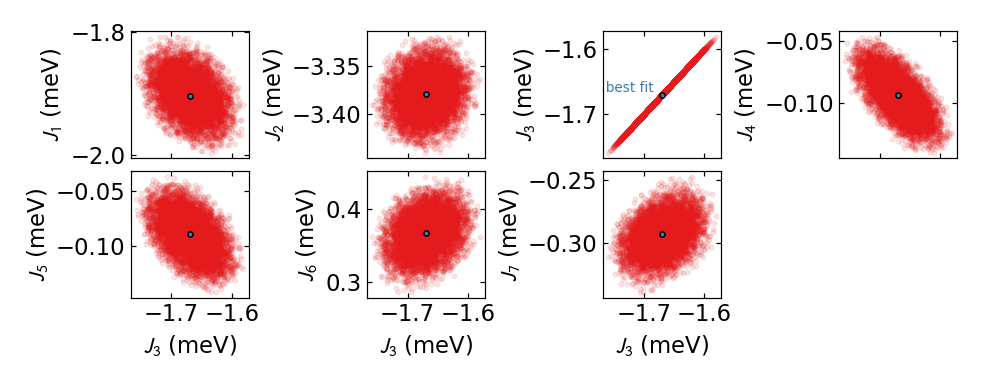

In [12]:
lowChisqJ2 = np.array(lowChisqJ2)

f, ax = plt.subplots(2,4,figsize=(9,3.5), sharex=True)
axes= ax.flatten()

n = 2
for i, axx in enumerate(axes):
    jind = i       
    try:
        axx.plot(lowChisqJ2[:,n]*sf, lowChisqJ2[:,jind]*sf, alpha=0.1, **markerprops)
        axx.set_ylabel('$J_{'+str(jind+1)+'}$ (meV)')
        axx.plot(JJglobalbest[n]*sf, JJglobalbest[jind]*sf, ms=7, mec='k', ls='none', marker='.')
        if i == n:
            axx.text(JJglobalbest[n]*sf, JJglobalbest[jind]*sf, 
                 '  best fit  ', color=pf.cpal1[1], fontsize=9, va='bottom', ha='right')
    except IndexError:
        axx.axis('off')
        
for i in range(len(ax[0])):
    ax[-1,i].set_xlabel('$J_{'+str(n+1)+'}$ (meV)')
    
plt.tight_layout()
f.subplots_adjust(wspace=1.0, hspace=0.1)

<IPython.core.display.Javascript object>


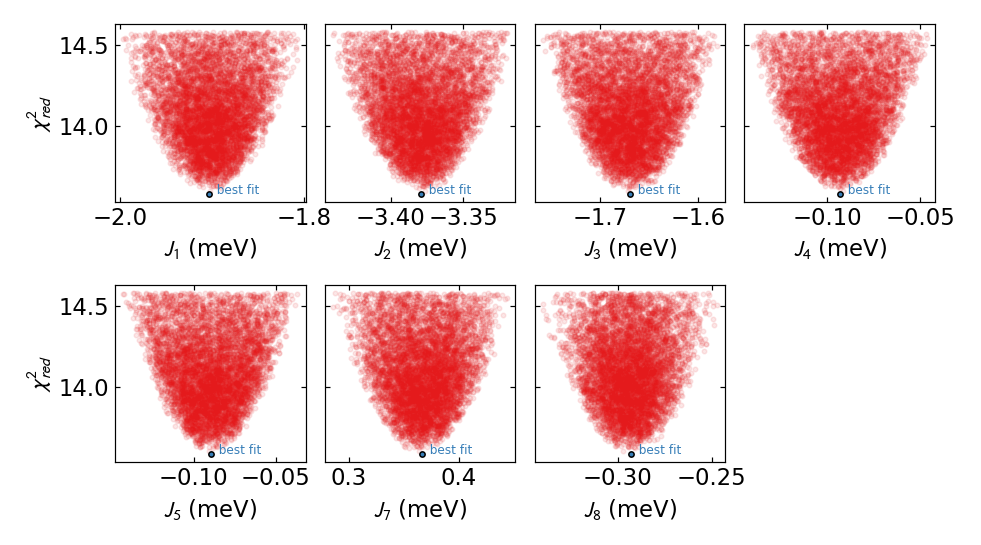

In [13]:
f, ax = plt.subplots(2,4,figsize=(9,5), sharey=True)

markerprops = {'ls':'none', 'marker':'.', 'rasterized':True}

axes= ax.flatten()
for i, axx in enumerate(axes):
    jind = i        
    try:
        #axx.plot(JJ_list[:,jind]*sf, Chisq_list, alpha=0.2, **markerprops)
        axx.plot(lowChisqJ2[:,jind]*sf, lowChisqChi2, alpha=0.1, **markerprops)
        axx.set_xlabel('$J_{'+str(exchnames[jind])+'}$ (meV)')
        axx.plot(JJglobalbest[jind]*sf, Chisqglobalbest, ms=7, mec='k', ls='none', marker='.')
        axx.text(JJglobalbest[jind]*sf, Chisqglobalbest, '  best fit', color=pf.cpal1[1], fontsize=8)
    except IndexError:
        axx.axis('off')
        
for i in range(len(ax)):
    ax[i,0].set_ylabel('$\\chi^2_{red}$')

plt.tight_layout()
f.subplots_adjust(wspace=0.1)